# Set up the environment

You need to install Python, NumPy, Pandas, Matplotlib and Seaborn.

Done and ready to go.

## Imports

In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split


%matplotlib inline

---

# Homework

> Note: sometimes your answer doesn't match one of the options exactly. That's fine. Select the option that's closest to your solution.

## Dataset

In this homework, we will use the California Housing Prices data from Kaggle.

Here's a wget-able link:

* `wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv`

We'll keep working with the 'median_house_value' variable, and we'll transform it to a classification task.

## Features

For the rest of the homework, you'll need to use only these columns:

* latitude
* longitude
* housing_median_age
* total_rooms
* total_bedrooms
* population
* households
* median_income
* median_house_value
* ocean_proximity


In [3]:
# Let's get the data
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-09-25 00:34:12--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.2’

housing.csv.2       100%[===================>]   1.36M  7.82MB/s    in 0.2s    

2022-09-25 00:34:12 (7.82 MB/s) - ‘housing.csv.2’ saved [1423529/1423529]



---

## Data preparation

* Select only the features from above and fill in the missing values with 0.
* Create a new column rooms_per_household by dividing the column total_rooms by the column households from dataframe.
* Create a new column bedrooms_per_room by dividing the column total_bedrooms by the column total_rooms from dataframe.
* Create a new column population_per_household by dividing the column population by the column households from dataframe.

In [4]:
# Load the data
df = pd.read_csv("housing.csv")

In [5]:
# No need to drop columns as the dataset only contains the required columns
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [6]:
# Fill in the missing values with 0
# Check for missing values
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
# Fille missing values with 0
df = df.fillna(0)

In [8]:
# Create a new column rooms_per_household by
#   dividing the column total_rooms by the column households from dataframe.
df["rooms_per_household"] = df.total_rooms / df.households

In [9]:
# Create a new column bedrooms_per_room by
#   dividing the column total_bedrooms by the column total_rooms from dataframe.
df["bedrooms_per_room"] = df.total_bedrooms / df.total_rooms

In [10]:
# Create a new column population_per_household by
#   dividing the column population by the column households from dataframe.
df["population_per_household"] = df.population / df.households

---

## Question 1

What is the most frequent observation (mode) for the column ocean_proximity?

Options:

* NEAR BAY
* **<1H OCEAN**
* INLAND
* NEAR OCEAN

In [11]:
# Use mode to find the most common ocean proximity value
df.ocean_proximity.mode()

0    <1H OCEAN
Name: ocean_proximity, dtype: object

In [12]:
# Veerify with value counts
df.ocean_proximity.value_counts().sort_values(ascending=False)

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

---

## Split the data

* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
* Make sure that the target value (median_house_value) is not in your dataframe.

In [13]:
# Function that takes a data frame and returns:
#  - Train, Validation and Test dataframes
#  - 60 / 20 / 20 split assumed
#  - randon seed is an optional valiable
def split_dataset(df, seed=42):
    # Create Full Train and Test Train Data frames
    df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=seed)

    # Split Full Train Data Set in Train and Validation
    df_train, df_val = train_test_split(
        df_train_full, test_size=0.25, random_state=seed
    )

    return df_train_full, df_train, df_val, df_test


# Create the Data Frames for the model
df_train_full, df_train, df_val, df_test = split_dataset(df)

# The values to predict
y_train_full = df_train.median_house_value.values
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values

# Remove target from Training / Validation datasets
del df_train_full["median_house_value"]
del df_train["median_house_value"]
del df_val["median_house_value"]

---

## Question 2

* Create the correlation matrix for the numerical features of your train dataset.
    * In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.
* What are the two features that have the biggest correlation in this dataset?

Options:

* **`total_bedrooms` and `households`**
* `total_bedrooms` and `total_rooms`
* `population` and `households`
* `population_per_household` and `total_rooms`

### Useful Links:

* [Correlation Matrix](https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas)
* [Highest Correlation](https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas)

In [14]:
# Create a correlation matrix
corr = df_train.corr()
corr.style.background_gradient(cmap="coolwarm")

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household
longitude,1.000000,-0.925005,-0.099812,0.036449,0.063840,0.091670,0.049762,-0.016426,-0.034814,0.102320,0.011022
latitude,-0.925005,1.000000,0.002477,-0.025914,-0.059730,-0.100272,-0.063529,-0.076805,0.119118,-0.124507,-0.002301
housing_median_age,-0.099812,0.002477,1.000000,-0.363522,-0.324156,-0.292476,-0.306119,-0.119591,-0.181275,0.129456,0.012167
total_rooms,0.036449,-0.025914,-0.363522,1.000000,0.931546,0.853219,0.921441,0.198951,0.168926,-0.194185,-0.029452
total_bedrooms,0.063840,-0.059730,-0.324156,0.931546,1.000000,0.877340,0.979399,-0.009833,0.010381,0.078094,-0.034301
population,0.091670,-0.100272,-0.292476,0.853219,0.877340,1.000000,0.906841,-0.000849,-0.076210,0.031592,0.064998
households,0.049762,-0.063529,-0.306119,0.921441,0.979399,0.906841,1.000000,0.011925,-0.085832,0.058004,-0.032522
median_income,-0.016426,-0.076805,-0.119591,0.198951,-0.009833,-0.000849,0.011925,1.000000,0.394154,-0.616617,-0.000454
rooms_per_household,-0.034814,0.119118,-0.181275,0.168926,0.010381,-0.076210,-0.085832,0.394154,1.000000,-0.500589,0.001801
bedrooms_per_room,0.102320,-0.124507,0.129456,-0.194185,0.078094,0.031592,0.058004,-0.616617,-0.500589,1.000000,-0.002851


<AxesSubplot:>

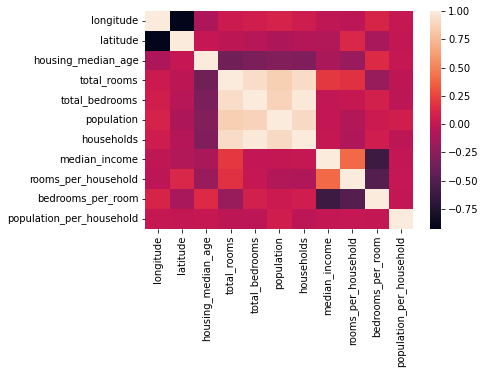

In [15]:
# Display using Seaborn
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
)

In [16]:
def get_redundant_pairs(df):
    """Get diagonal and lower triangular pairs of correlation matrix"""
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i + 1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [17]:
# Get the highest correlation value
print(get_top_abs_correlations(corr, 3))

total_bedrooms  households    0.997812
population      households    0.992294
longitude       latitude      0.990133
dtype: float64


---

## Make median_house_value binary

* We need to turn the `median_house_value` variable from numeric into binary.
* Let's create a variable `above_average` which is 1 if the `median_house_value` is above its mean value and 0 otherwise.

It is not clear here whether the mean value to use is for:

* The full data set
* The full training data set
* The training data set
* The validation data set
* The test data set

The most logical value to use is the mean from the full data set.

In [18]:
# Add the new binary `above_average` variable to the full data frame
df["above_average"] = np.where(
    df.median_house_value > df.median_house_value.mean(), 1, 0
)

In [19]:
df["above_average"].value_counts()

0    12255
1     8385
Name: above_average, dtype: int64

In [20]:
# Create the Data Frames for the model
df_train_full, df_train, df_val, df_test = split_dataset(df)

# The values to predict
y_train_full = df_train.above_average.values
y_train = df_train.above_average.values
y_val = df_val.above_average.values

---

## Question 3

* Calculate the mutual information score with the (binarized) price for the categorical variable that we have. Use the training set only.
* What is the value of mutual information?
* Round it to 2 decimal digits using round(score, 2)

Options:

* 0.26
* 0
* **0.10**
* 0.16

In [21]:
# Function to apply mutual info score function
def calculate_mi(series):
    return mutual_info_score(series, df_train.above_average)


# The list of categorical variables
categorical = ["ocean_proximity"]

# Calculate and display mutual info score
df_mi = df_train[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name="MI")
df_mi.head().round(2)

,MI
ocean_proximity,0.1


---

## Question 4

* Now let's train a logistic regression
* Remember that we have one categorical variable ocean_proximity in the data. Include it using one-hot encoding.
* Fit the model on the training dataset.
    * To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
    * `model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)`
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

Options:

* 0.60
* 0.72
* **0.84**
* 0.95

In [22]:
# Define Numerical and Categorical Data

# The list of categorical variables
categorical = ["ocean_proximity"]

# The list of numerical variables
numerical = [
    "longitude",
    "latitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
    "rooms_per_household",
    "bedrooms_per_room",
    "population_per_household",
]

# Create a Dictionary of the Training Data set Records
train_dict = df_train[categorical + numerical].to_dict(orient="records")

# Create the DictVectorizer object, fit and transform
# Giving the training data set
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

In [23]:
dv.get_feature_names_out()

array(['bedrooms_per_room', 'households', 'housing_median_age',
       'latitude', 'longitude', 'median_income',
       'ocean_proximity=<1H OCEAN', 'ocean_proximity=INLAND',
       'ocean_proximity=ISLAND', 'ocean_proximity=NEAR BAY',
       'ocean_proximity=NEAR OCEAN', 'population',
       'population_per_household', 'rooms_per_household',
       'total_bedrooms', 'total_rooms'], dtype=object)

#### Training logistic regression

In [24]:
# Create the model
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)

# Fit the model with the Training Data
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [25]:
# Calculate the accuracy on the validation dataset and round it to 2 decimal digits

# Create a Dictionary of the Validation Data set Records
#   and transform
val_dict = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dict)

In [26]:
# Show the model predictions
model.predict_proba(X_val)

array([[0.92659756, 0.07340244],
       [0.82204886, 0.17795114],
       [0.04870942, 0.95129058],
       ...,
       [0.03664814, 0.96335186],
       [0.14673774, 0.85326226],
       [0.54428458, 0.45571542]])

In [27]:
# Predict the validation above / below average using the model
y_pred = model.predict_proba(X_val)[:, 1]

# Convert probabilities to binary
averages = y_pred > 0.5

# Calculate the accuracy
round((y_val == averages).mean(), 2)

0.84

---

## Question 5

* Let's find the least useful feature using the feature elimination technique.
* Train a model with all these features (using the same parameters as in Q4).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

Which of following feature has the smallest difference?

* `total_rooms`
* `total_bedrooms`
* `population`
* **`households`**

> note: the difference doesn't have to be positive

In [28]:
# The feature
features = ["total_rooms", "total_bedrooms", "population", "households"]

In [29]:
# Define a function to train the model, predict and calculate accuracy
def model_pipe(features):

    # Create a Dictionary of the Training Data set Records
    train_dict = df_train[features].to_dict(orient="records")

    # Create the DictVectorizer object, fit and transform
    # Giving the training data set
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)
    X_train = dv.transform(train_dict)

    # Create the model
    model = LogisticRegression(
        solver="liblinear", C=1.0, max_iter=1000, random_state=42
    )

    # Fit the model with the Training Data
    model.fit(X_train, y_train)

    # Calculate the accuracy on the validation dataset and round it to 2 decimal digits

    # Create a Dictionary of the Validation Data set Records
    #   and transform
    val_dict = df_val[categorical + numerical].to_dict(orient="records")
    X_val = dv.transform(val_dict)

    # Predict the validation above / below average using the model
    y_pred = model.predict_proba(X_val)[:, 1]

    # Convert probabilities to binary
    averages = y_pred > 0.5

    # Calculate the accuracy and return
    return round((y_val == averages).mean(), 2)

In [30]:
# Calculate accuracy with all features
all_features_acc = model_pipe(features)

In [31]:
# Iterate over the features, removing one at a time
for n in range(4):
    rm = features[n]
    n_acc = model_pipe(features[:n] + features[n + 1 :])

    print(f"Without Feature: {rm}")
    print(f"Accuracy:        {round(n_acc, 3)}")
    print(f"Difference:      {round(abs(all_features_acc - n_acc), 2)}")
    print(f"Features Used:   {features[:n] + features[n + 1 :]} \n")

Without Feature: total_rooms
Accuracy:        0.63
Difference:      0.08
Features Used:   ['total_bedrooms', 'population', 'households'] 

Without Feature: total_bedrooms
Accuracy:        0.66
Difference:      0.05
Features Used:   ['total_rooms', 'population', 'households'] 

Without Feature: population
Accuracy:        0.66
Difference:      0.05
Features Used:   ['total_rooms', 'total_bedrooms', 'households'] 

Without Feature: households
Accuracy:        0.67
Difference:      0.04
Features Used:   ['total_rooms', 'total_bedrooms', 'population'] 



---

## Question 6

* For this question, we'll see how to use a linear regression model from Scikit-Learn
* We'll need to use the original column 'median_house_value'. Apply the logarithmic transformation to this column.
* Fit the Ridge regression model (model = Ridge(alpha=a, solver="sag", random_state=42)) on the training data.
* This model has a parameter alpha. Let's try the following values: [0, 0.01, 0.1, 1, 10]
* Which of these alphas leads to the best RMSE on the validation set? Round your RMSE scores to 3 decimal digits.

If there are multiple options, select the smallest alpha.

Options:

* **0**
* 0.01
* 0.1
* 1
* 10

In [32]:
# Refresh the training / validation / test data and set y values

# Create the Data Frames for the model
df_train_full, df_train, df_val, df_test = split_dataset(df)

# The values to predict
y_train_full = df_train.median_house_value.values
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values

In [33]:
# Create a Dictionary of the Training Data set Records
train_dict = df_train[categorical + numerical].to_dict(orient="records")

# Create the DictVectorizer object, fit and transform
# Giving the training data
setdv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)


# Create a Dictionary of the Validation Data set Records
#   and transform
val_dict = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dict)

results = []

# Calculate the best (lowest) RMSE for various alpha values
for alpha_ in [0, 0.01, 0.1, 1, 10]:
    model = model = Ridge(alpha=alpha_, solver="sag", random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    score = np.sqrt(mean_squared_error(y_val, y_pred))

    results.append((alpha_, round(score, 3)))

sorted(results, key=lambda element: (element[1], element[0]))

[(0, 106337.775),
 (0.01, 106337.775),
 (0.1, 106337.775),
 (1, 106337.775),
 (10, 106337.778)]

---

# Learning in Public

* https://twitter.com/David__Colton/status/1570914809276944387?s=20&t=eZO60u5QQNHcSkg-nECxlQ
* https://twitter.com/David__Colton/status/1571053726156361731?s=20&t=-Pi6a3qo_7vWU6sO4yFfLQ
* https://twitter.com/David__Colton/status/1571200545364254733?s=20&t=0JW9xokk1s-Nv5qPn0tasA
* https://twitter.com/David__Colton/status/1571278188600238080?s=20&t=37XhD-mKRJ_9aK0SWqszEA
* https://twitter.com/David__Colton/status/1571488901956526081?s=20&t=wIxNgvN28U6LGFpCSQ7J_g
* https://twitter.com/David__Colton/status/1571949625178820608?s=20&t=G6LBsdp1BfZ6A42xnwqf6A
* https://twitter.com/David__Colton/status/1571980606883635201?s=20&t=cxia6efxXTzVVwVtucx2LA
* https://twitter.com/David__Colton/status/1572293070510759938?s=20&t=lIqSfPUHXI64KwJxY5BfUQ
* https://twitter.com/David__Colton/status/1572308189802303490?s=20&t=8UiOn5sTFBHB6MCSV-yb1Q
* https://twitter.com/David__Colton/status/1572716014844145666?s=20&t=Ve4R95j_pUJj1ZmYXxQWfg
* https://twitter.com/David__Colton/status/1573064716716736512?s=20&t=f5Cto1UpRElKW1lqobRc_w
* https://twitter.com/David__Colton/status/1573072103078772736?s=20&t=A6YkuyC9rqDxv74gLJmWvQ

---

* https://twitter.com/David__Colton/status/1571054541357056002?s=20&t=-Pi6a3qo_7vWU6sO4yFfLQ